# Imports and General Settings

In [1]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


/device:GPU:0


# Loading Data

## Data Augmentation Functions

In [2]:

def rotate(image):
    
    return tf.image.rot90(image, tf.random_uniform(shape=[], minval=0, maxval=4, 
                                               dtype=tf.int32))

def flip(image):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image

def crop(image, range_start=0.8, range_end=1.0):
    
    image = tf.image.central_crop(image, central_fraction=random.uniform(range_start, range_end))
    image = tf.image.resize_images(image,tf.constant([512, 512]))
    return image

def translate(image,  x_max=75, y_max=75):
    
    return tf.contrib.image.translate(image, translations=[random.uniform(-1 * x_max, x_max), 
                                                           random.uniform(-1 * y_max, y_max)])

def augment_image(image):
                       
    image = rotate(image)
    image = flip(image)
    
    image = translate(image)
    image = crop(image)

    return image

## Importing Data (PNG)

Given a directory of data of the form: ~/data/labels/images.png

In [28]:
# load an array of image paths
def load_image_paths(path):
    
    data_root = pathlib.Path(path)
    
    # create a list of every file and its label index
    all_image_paths = list(data_root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    
    return all_image_paths

# randomly shuffle train and test values and split based on parameters
def split(image_paths, split=[0.6,0.2,0.2], seed=777):
    random.Random(seed).shuffle(image_paths)
    
    boundary1 = int(len(image_paths) * split[0])
    boundary2 = int(len(image_paths) * (split[0]+split[1]))
    
    train = image_paths[:boundary1]
    evaluate = image_paths[boundary1: boundary2]
    test = image_paths[boundary2:]
    
    return train, evaluate, test

# preprocessing functions
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape=[512,512])
    image = image / 255.0
    
#     image = tf.div(
#        tf.subtract(
#           image, 
#           tf.reduce_min(image)
#        ), 
#        tf.subtract(
#           tf.reduce_max(image), 
#           tf.reduce_min(image)
#        )
#     )
    
    
    
    return image

def load_and_preprocess_image(path, augment=True):
    image = tf.read_file(path)
    image = preprocess_image(image)
    
    if (augment):
        image = augment_image(image[:,:,None])
    
    return image

def load(path, image_paths, training=True, augment=True, batch_size=64, shuffle=True, drop_remainder=False):
    with tf.device("/CPU:0"):
        # data root
        data_root = pathlib.Path(path)

        # return label names
        label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

        # assign index to label
        label_to_index = dict((name, index) for index,name in enumerate(label_names))

        # array of all labels corresponding to image_paths
        all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                            for path in image_paths]

        # make path dataset
        path_ds = tf.data.Dataset.from_tensor_slices(image_paths)

        # get image tensors by mapping function over the path dataset
        image_ds = path_ds.map(lambda path : load_and_preprocess_image(path, augment=augment))

        # create label dataset
        label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

        # zip together image and label dataset into dataset of tuples for
        # estimator input
        image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

        # Setting a shuffle buffer size as large as the dataset ensures that the data is
        # completely shuffled
        
        image_label_ds = image_label_ds.batch(batch_size, drop_remainder=drop_remainder)
        
        if (training):
            print("shuffling and repeating b/c training flag set")

            image_label_ds = image_label_ds.repeat()
        else:
            image_label_ds = image_label_ds.repeat(count=1)
        
        
        if (shuffle):
            image_label_ds = image_label_ds.shuffle(buffer_size = 5 * batch_size)
            
        # `prefetch` lets the dataset fetch batches, in the background while the model is training.
        image_label_ds = image_label_ds.prefetch(6)
       
        
        return image_label_ds

# Tensorboard

## Logging Convolution Filters

In [29]:
@tfplot.wrap
def plot_conv_weights(weights, channels_all=True):
    """
    Plots convolutional filters
    :param weights: numpy array of rank 4
    :param channels_all: boolean, optional

    """
    w_min = np.min(weights)
    w_max = np.max(weights)

    channels = [0]
    # make a list of channels if all are plotted
    if channels_all:
        channels = range(weights.shape[2])

    # get number of convolutional filters
    num_filters = weights.shape[3]

    # get number of grid rows and columns
    grid_r, grid_c = log_util.get_grid_dim(num_filters)
    
    # create figure and axes
    fig, axes = plt.subplots(min([grid_r, grid_c]), max([grid_r, grid_c]))

    # iterate channels
    for channel in channels:
        # iterate filters inside every channel
        for l, ax in enumerate(axes.flat):
            # get a single filter
            img = weights[:, :, channel, l]
            # put it on the grid
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
            
            # remove any labels from the axes
            ax.set_xticks([])
            ax.set_yticks([])
            
    plt.close(fig)
    
    return fig


## Logging Activation Maps

In [12]:
@tfplot.wrap
def plot_conv_output(conv_img, name):
    """
    Makes plots of results of performing convolution
    :param conv_img: numpy array of rank 4
    :param name: string, name of convolutional layer
    :return: nothing, plots are saved on the disk
    """
    w_min = np.min(conv_img)
    w_max = np.max(conv_img)

    # get number of convolutional filters
    num_filters = conv_img.shape[3]

    # get number of grid rows and columns
    grid_r, grid_c = log_util.get_grid_dim(num_filters)
    

    if (min([grid_r, grid_c]) == 1 and max([grid_r, grid_c]) == 1):
        
        fig, ax = plt.subplots(figsize=(24,24))   
        fig.suptitle(name, fontsize=25, color='k')
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        img = conv_img[0, :, :,  0]
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='bicubic', cmap='Greys_r')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.subplots_adjust(top=0.85)
        plt.close(fig)
        return fig
        
        
    # create figure and axes
    fig, axes = plt.subplots(min([grid_r, grid_c]),
                             max([grid_r, grid_c]),
                            figsize=(24,15))
    fig.suptitle(name, fontsize=25, color='k')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # iterate filters
    for l, ax in enumerate(axes.flat):
        # get a single image
        img = conv_img[0, :, :,  l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='bicubic', cmap='jet')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
       
    plt.close(fig)
    return fig
    
    

# ResNet

## ResNet-10 Architecture

In [13]:
num_classes = 3

# ResNet-10 architecture
def resnet10_network(x, conv_kernel=7, resblock_kernel=3, num_channels=4, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('Resnet-10', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.conv(x, num_channels, kernel=conv_kernel, stride=1, padding='SAME')
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock1_id1')      
   
        filtered_images.append(tf.identity(x))

        x = model_arch.resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, 
                     downsample=True, scope='resblock2_conv1')
        
        filtered_images.append(tf.identity(x))

        x = model_arch.resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock3_id2')
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels * 4, kernel=resblock_kernel, is_training=is_training, 
                     downsample=True, scope='resblock4_conv2')

        filtered_images.append(tf.identity(x))
        
        x = model_arch.resblock(x, channels=num_channels * 4, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock5_id3')
        
        filtered_images.append(tf.identity(x))
        
        
        x = model_arch.batch_norm(x, is_training, scope='batch_norm')
        
        x = model_arch.relu(x)
        
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def resnet10_model_fn(features, labels, mode, conv_kernel=7, resblock_kernel=3, num_channels=4, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = resnet10_network(features,
                                                          conv_kernel=conv_kernel,
                                                          resblock_kernel=resblock_kernel,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)

        logits_test, activ_maps_test, _ = resnet10_network(features,
                                                        conv_kernel=conv_kernel,
                                                        resblock_kernel=resblock_kernel,
                                                        num_channels=num_channels,
                                                        n_classes=num_classes,
                                                        reuse=True,
                                                        is_training=False)

        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(activ_maps_train), labels, 20.0, True)
        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        tf.summary.scalar("loss", loss_op)
        tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

            conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

            plot_op_expanded = tf.expand_dims(plot_conv_weights(conv0_weights), 0)
            tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                level_dict = {0 : "0_original_image",         
                              1 : "1_after_initial_conv",
                              2 : "2_after_resblock1_id1",
                              3 : "3_after_resblock2_conv1",
                              4 : "4_after_resblock3_id2",
                              5 : "5_after_resblock4_conv2",
                              6 : "6_after_resblock5_id3"}

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(plot_conv_output(activation_map, level_dict[counter]), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 1)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

## ResNet-4

In [25]:
num_classes = 3

# ResNet-10 architecture
def resnet4_network(x, conv_kernel=7, resblock_kernel=3, num_channels=4, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('Resnet-10', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x)) # initial image
        
        x = model_arch.conv(x, num_channels, kernel=conv_kernel, stride=1, padding='SAME')
        
        filtered_images.append(tf.identity(x)) # post conv
        
        x = model_arch.resblock(x, channels=num_channels, kernel=resblock_kernel, is_training=is_training, 
                      downsample=False, scope='resblock1_id1')      
   
        filtered_images.append(tf.identity(x)) # post resblock

        x = model_arch.resblock(x, channels=num_channels * 2, kernel=resblock_kernel, is_training=is_training, 
                     downsample=True, scope='resblock2_conv1')
        
        filtered_images.append(tf.identity(x))
        
        x = model_arch.batch_norm(x, is_training, scope='batch_norm')
        
        x = model_arch.relu(x)
        
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def resnet4_model_fn(features, labels, mode, conv_kernel=7, resblock_kernel=3, num_channels=4, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = resnet10_network(features,
                                                          conv_kernel=conv_kernel,
                                                          resblock_kernel=resblock_kernel,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)

        logits_test, activ_maps_test, _ = resnet10_network(features,
                                                        conv_kernel=conv_kernel,
                                                        resblock_kernel=resblock_kernel,
                                                        num_channels=num_channels,
                                                        n_classes=num_classes,
                                                        reuse=True,
                                                        is_training=False)

        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))

        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(activ_maps_train), labels, 20.0, True)
        
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        tf.summary.scalar("loss", loss_op)
        tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

            conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

            plot_op_expanded = tf.expand_dims(plot_conv_weights(conv0_weights), 0)
            tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                level_dict = {0 : "0_original_image",         
                              1 : "1_after_initial_conv",
                              2 : "2_after_resblock1_id1",
                              3 : "3_after_resblock2_conv1"}

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(plot_conv_output(activation_map, level_dict[counter]), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 1)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

# ResNet-4 Experimentation

In [27]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.01

random_seed = 777

num_steps = 10000

resnet4_checkpoint_path_base = "/data/jma/model/resnet4/relabeled_data/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [3, 5, 7]
filter_sizes = [8]
snnl_weights = [0.00]

data_root = "./data/data_relabeled_png/"

image_paths = load_image_paths(data_root)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)

train_input_fn = lambda : load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
eval_input_fn = lambda : load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
test_input_fn = lambda : load(data_root, test_paths, training=False, augment=False, shuffle=False)

for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet4_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)+"/"
            print(model_path)

            config = tf.estimator.RunConfig(
                log_step_count_steps= 20,
                save_summary_steps= 30,
                save_checkpoints_secs= 120,
                model_dir=model_path,
                tf_random_seed=random_seed,
                session_config=session_config)

            model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=False)

            model = tf.estimator.Estimator(model_fn=model_fn, config=config)

            train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
            eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=120)

            tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
        
        

/data/jma/model/resnet4/relabeled_data/kernel3_filter8_snnl0.0/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/resnet4/relabeled_data/kernel3_filter8_snnl0.0/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc00d7cfa20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and eval

KeyboardInterrupt: 

## ResNet-10 Experimentation

In [19]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.01

random_seed = 777

num_steps = 500

resnet10_checkpoint_path_base = "/data/jma/model/resnet10/old_data/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [3, 5, 7]
filter_sizes = [8]
snnl_weights = [0.00]

data_root = "./data/data_initial_labels_png//"

image_paths = load_image_paths(data_root)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)

train_input_fn = lambda : load(data_root, train_paths, training=True, augment=True, batch_size=32, shuffle=False)
eval_input_fn = lambda : load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
test_input_fn = lambda : load(data_root, test_paths, training=False, augment=False, shuffle=False)

for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)+"/"
            print(model_path)

            config = tf.estimator.RunConfig(
                log_step_count_steps= 20,
                save_summary_steps= 30,
                save_checkpoints_secs= 120,
                model_dir=model_path,
                tf_random_seed=random_seed,
                session_config=session_config)

            model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=False)

            model = tf.estimator.Estimator(model_fn=model_fn, config=config)

            train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
            eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=120)

            tf.estimator.train_and_evaluate(model, train_spec, eval_spec)
        
        

/data/jma/model/resnet10/old_data/kernel3_filter8_snnl0.0/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/resnet10/old_data/kernel3_filter8_snnl0.0/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc33ff02cc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop.

INFO:tensorflow:global_step/sec: 2.50381
INFO:tensorflow:loss = 0.8286184, step = 140 (7.987 sec)
INFO:tensorflow:global_step/sec: 2.64657
INFO:tensorflow:loss = 1.4243879, step = 160 (7.557 sec)
INFO:tensorflow:global_step/sec: 2.51074
INFO:tensorflow:loss = 0.8288275, step = 180 (7.965 sec)
INFO:tensorflow:global_step/sec: 2.52221
INFO:tensorflow:loss = 0.60481083, step = 200 (7.928 sec)
INFO:tensorflow:global_step/sec: 2.54
INFO:tensorflow:loss = 0.80835104, step = 220 (7.874 sec)
INFO:tensorflow:global_step/sec: 2.6087
INFO:tensorflow:loss = 0.7032138, step = 240 (7.668 sec)
INFO:tensorflow:global_step/sec: 2.51478
INFO:tensorflow:loss = 0.6250069, step = 260 (7.953 sec)
INFO:tensorflow:global_step/sec: 2.50036
INFO:tensorflow:loss = 0.6904664, step = 280 (8.000 sec)
INFO:tensorflow:global_step/sec: 2.50215
INFO:tensorflow:loss = 0.56228036, step = 300 (7.993 sec)
INFO:tensorflow:Saving checkpoints for 302 into /data/jma/model/resnet10/old_data/kernel5_filter8_snnl0.0/model.ckpt.
I

INFO:tensorflow:global_step/sec: 2.72705
INFO:tensorflow:loss = 0.2859722, step = 480 (7.336 sec)
INFO:tensorflow:Saving checkpoints for 500 into /data/jma/model/resnet10/old_data/kernel7_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (120 secs).
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-30-23:38:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/resnet10/old_data/kernel7_filter8_snnl0.0/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-30-23:38:51
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.54658383, global_step = 500, loss = 1.2413918
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /data/jma/model/resnet10/old_data/kernel7_filter8_snnl0.0/model.ckpt-500
INFO:tensorfl

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

resnet10_checkpoint_path_base = "/data/jma/model/resnet10/relabeled_data/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [3, 5, 7]
filter_sizes = [8]
snnl_weights = [0.05]

data_root = "./data/data_relabeled_png/"

image_paths = load_image_paths(data_root)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


eval_input_fn = lambda : load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)+"/"
            print(model_path)

            model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

# Metrics

## Metric Utility Functions

In [20]:
def path_to_label(paths, data_root):

    data_root = pathlib.Path(data_root)

    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

    # assign index to label
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels


## Confusion Matrices

/data/jma/model/resnet10/relabeled_data/kernel3_filter4_snnl0.0/
in gpu part


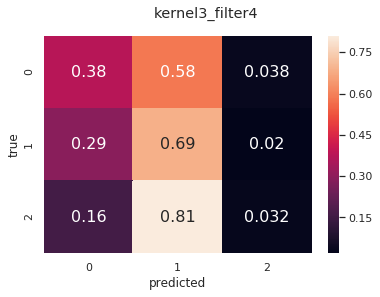

/data/jma/model/resnet10/relabeled_data/kernel5_filter4_snnl0.0/
in gpu part


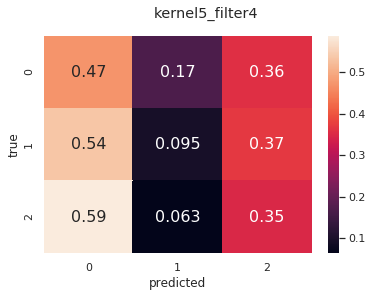

/data/jma/model/resnet10/relabeled_data/kernel7_filter4_snnl0.0/
in gpu part


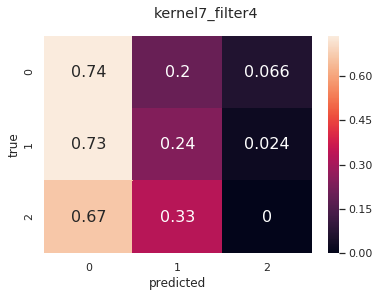

/data/jma/model/resnet10/relabeled_data/kernel3_filter8_snnl0.0/
in gpu part


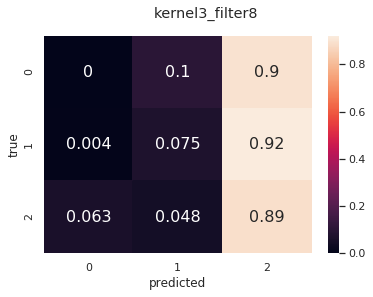

/data/jma/model/resnet10/relabeled_data/kernel5_filter8_snnl0.0/
in gpu part


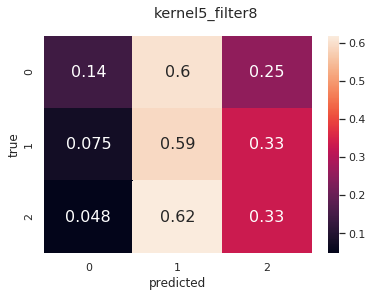

/data/jma/model/resnet10/relabeled_data/kernel7_filter8_snnl0.0/
in gpu part


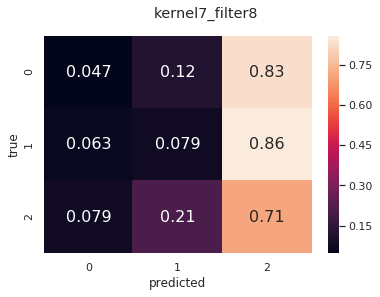

In [24]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

resnet10_checkpoint_path_base = "/data/jma/model/resnet10/relabeled_data/"

kernel_sizes = [3,5,7]
filter_sizes = [4,8]
snnl_weights = [0.00]

data_path = "./data/data_relabeled_png//"

random_seed = 777

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


eval_input_fn = lambda : load(data_path, eval_paths, training=False, augment=False, shuffle=False, batch_size=64)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()

            title = "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight)
            
            model_path = resnet10_checkpoint_path_base + title +"/"
            print(model_path)
        
        
            model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                                        conv_kernel=kernel_size, 
                                                                        num_channels=filter_size)
            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            values = model.predict(eval_input_fn)


            original_labels = path_to_label(eval_paths, data_path)
            predicted_labels = list(values)

            cm = tf.confusion_matrix(original_labels, predicted_labels)
            cm = tf.to_float(cm)

            cm = cm.numpy()
            
            row_sums = cm.sum(axis=1)
            cm = cm / row_sums[:, np.newaxis]
            
            df_cm = pd.DataFrame(cm, range(3), range(3))
            #plt.figure(figsize = (10,7))

            sns.set(font_scale=1)#for label size
            plt.suptitle("kernel" + str(kernel_size) + "_filter" + str(filter_size))
            ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
            ax.set(xlabel='predicted', ylabel='true')
            plt.show()
        

## Incorrectly Classified Images (PNG Format)

/data/jma/model/resnet10/old_data/kernel5_filter8/
in gpu part


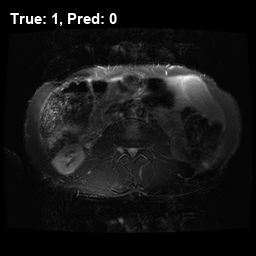

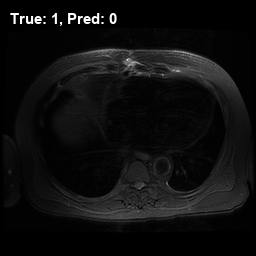

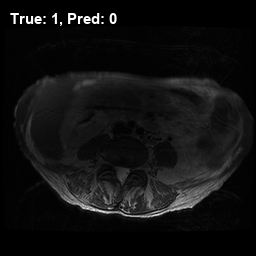

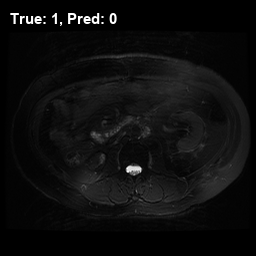

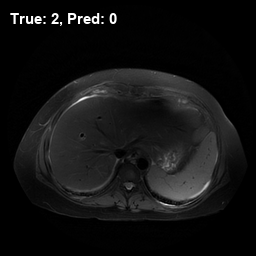

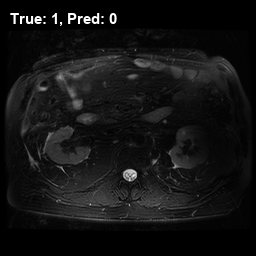

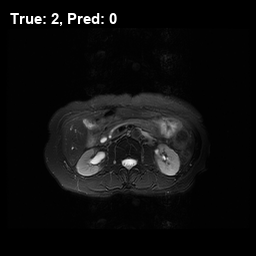

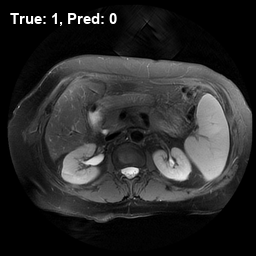

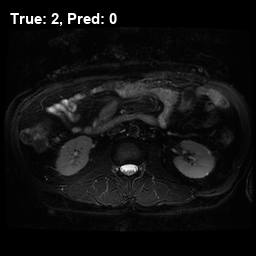

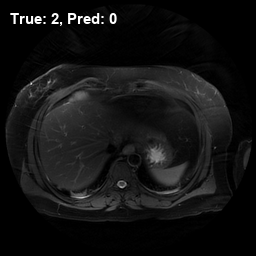

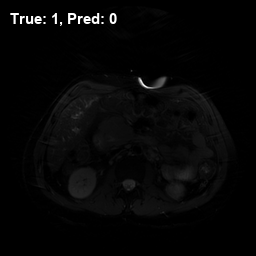

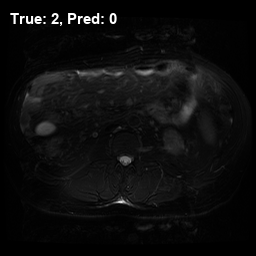

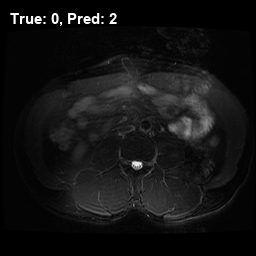

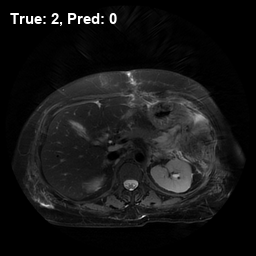

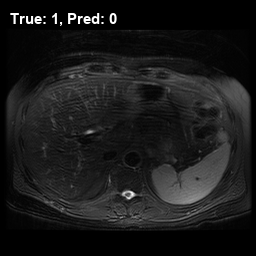

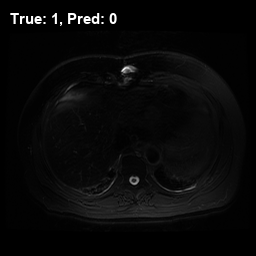

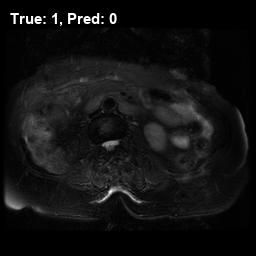

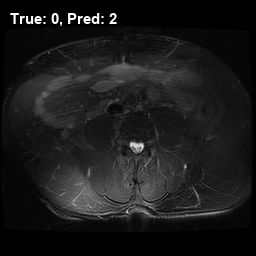

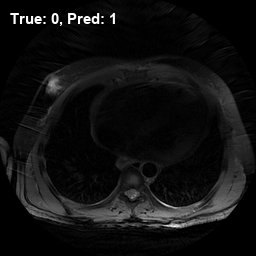

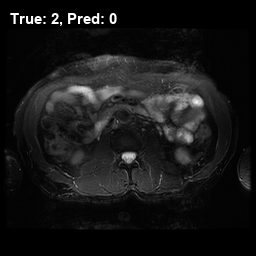

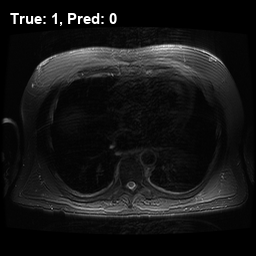

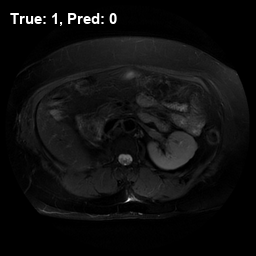

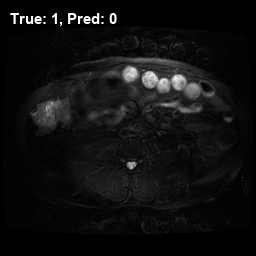

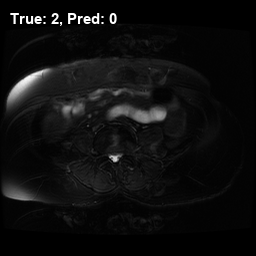

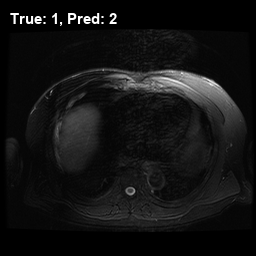

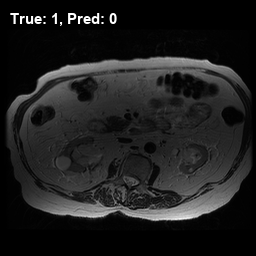

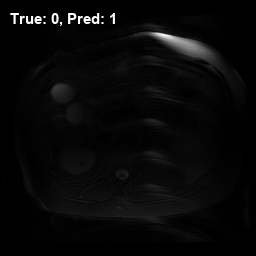

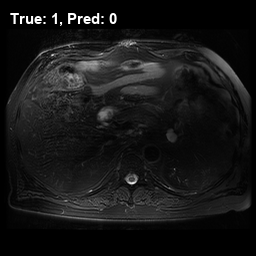

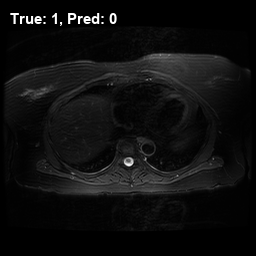

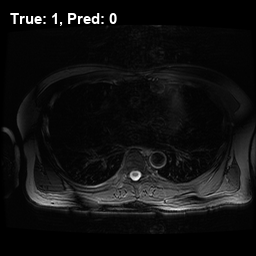

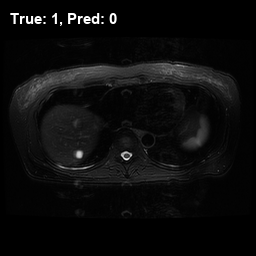

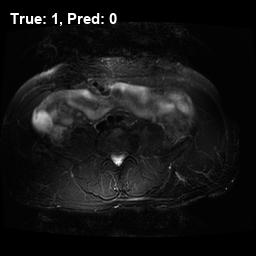

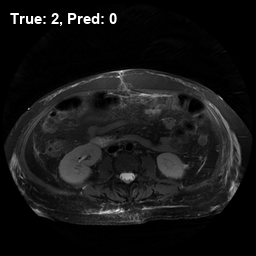

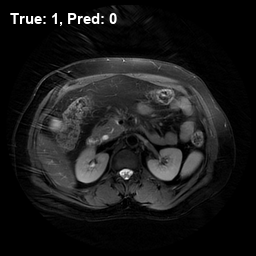

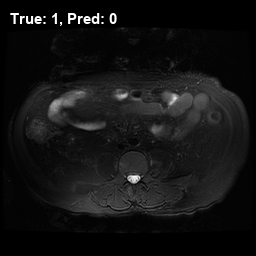

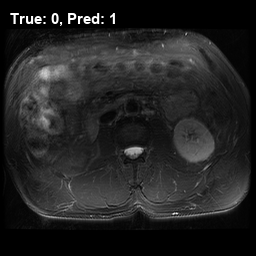

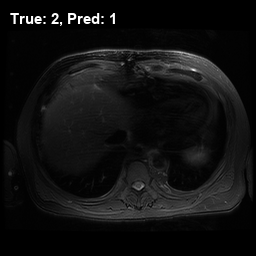

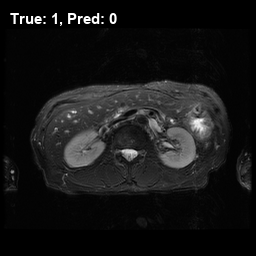

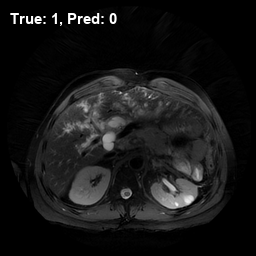

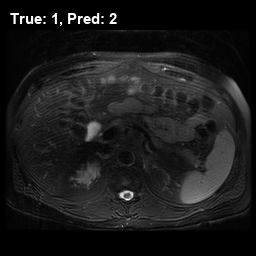

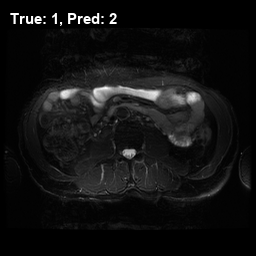

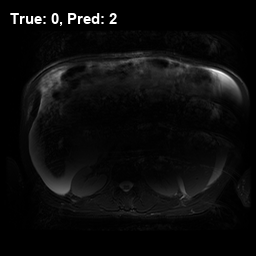

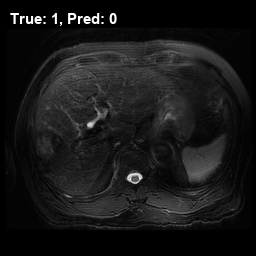

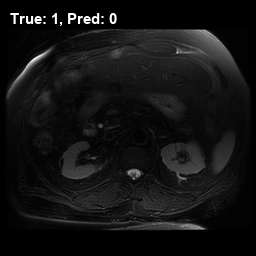

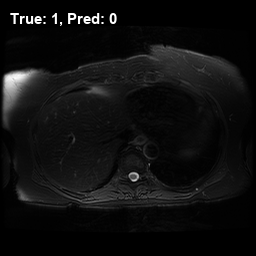

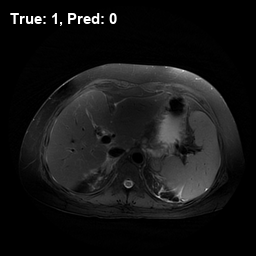

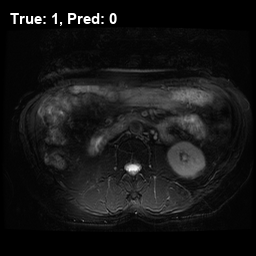

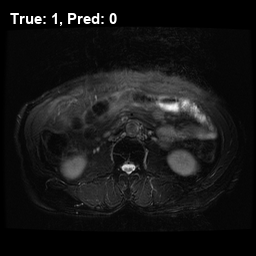

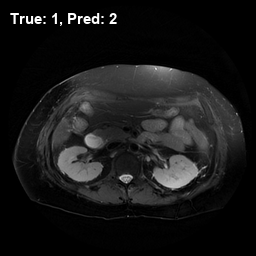

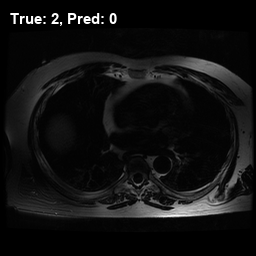

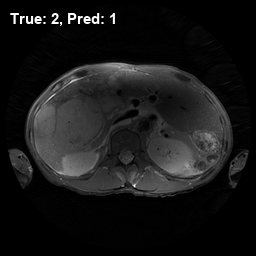

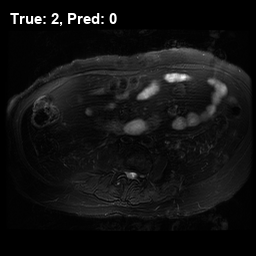

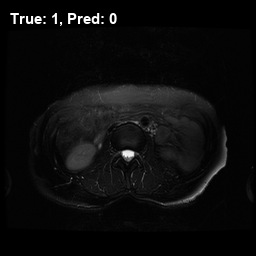

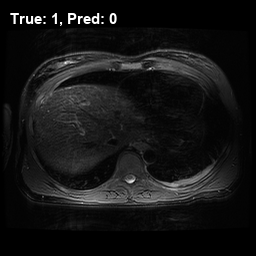

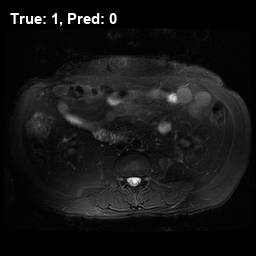

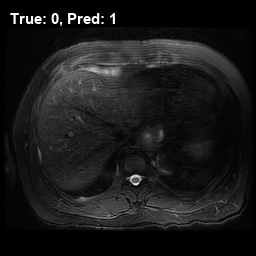

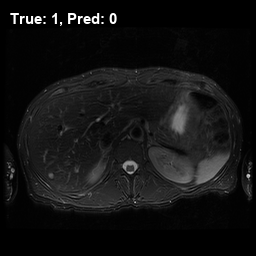

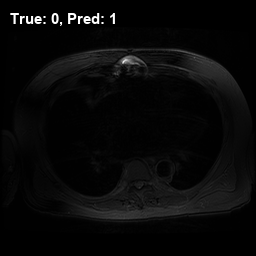

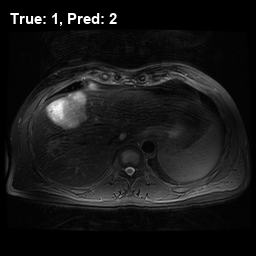

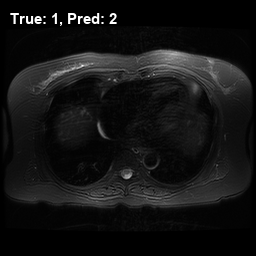

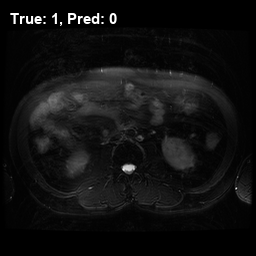

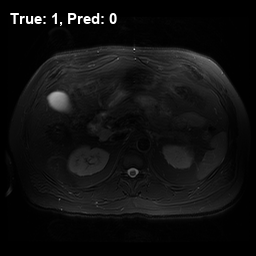

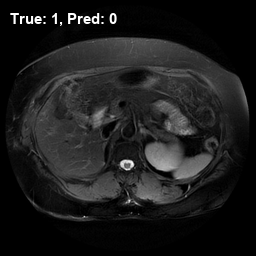

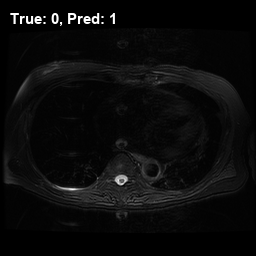

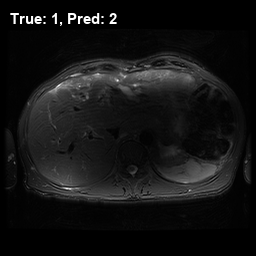

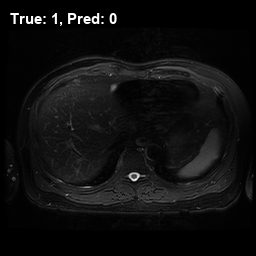

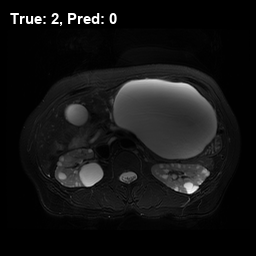

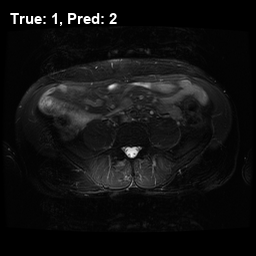

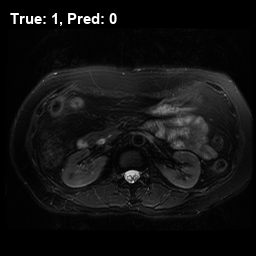

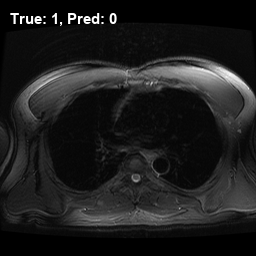

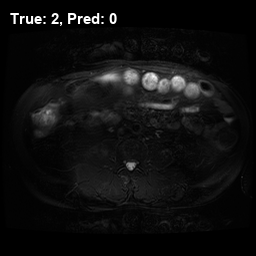

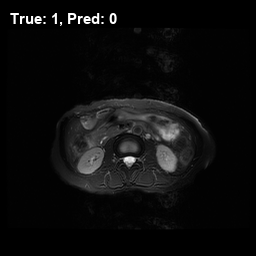

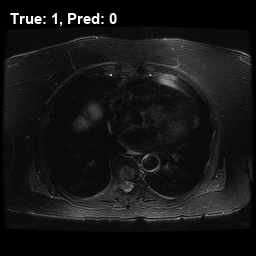

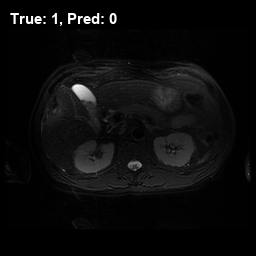

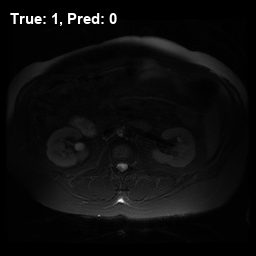

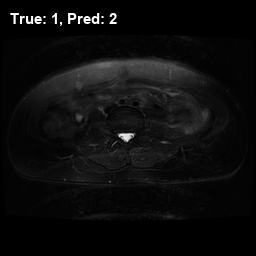

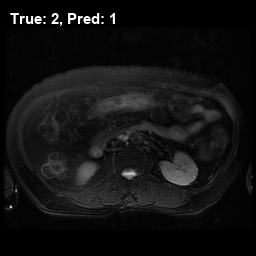

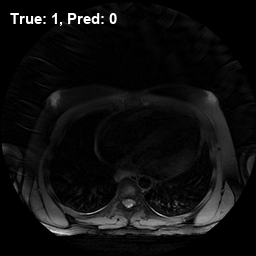

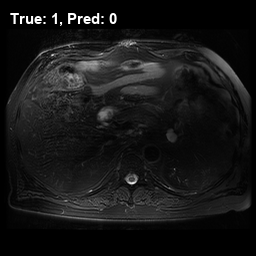

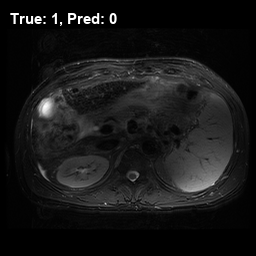

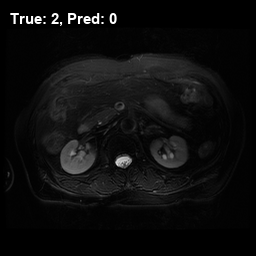

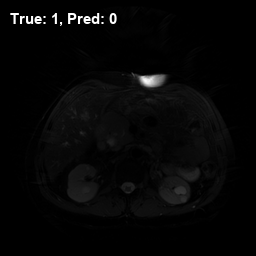

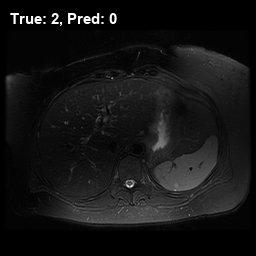

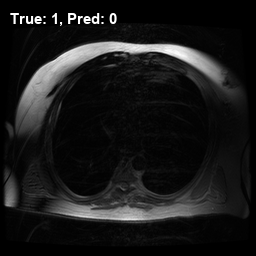

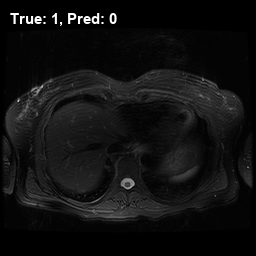

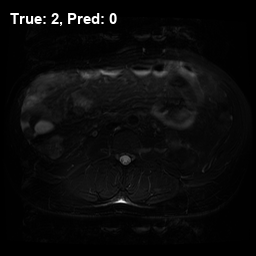

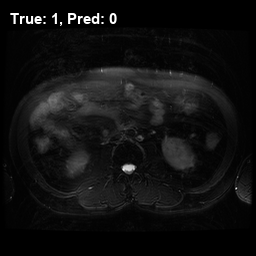

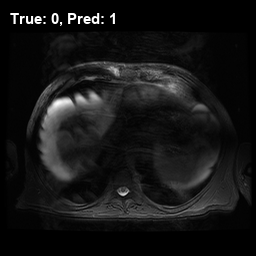

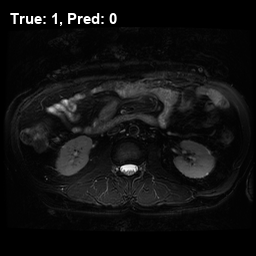

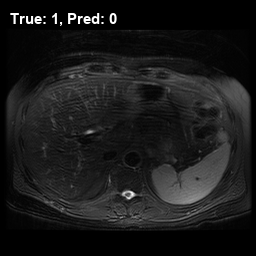

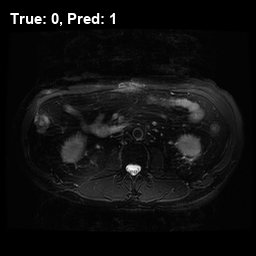

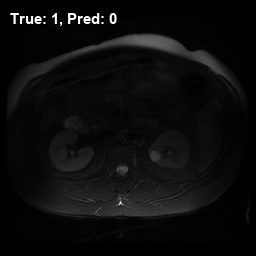

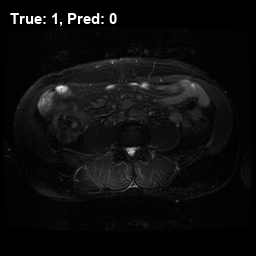

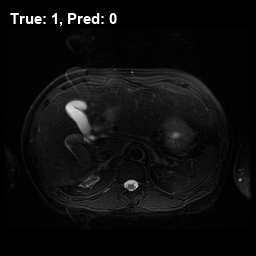

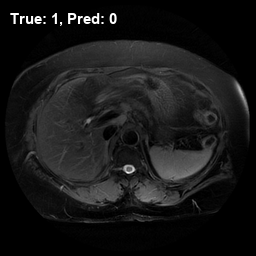

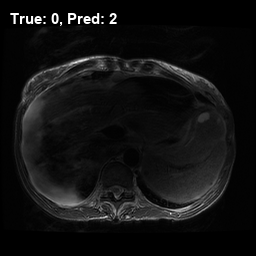

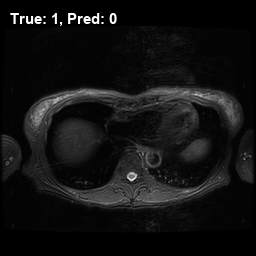

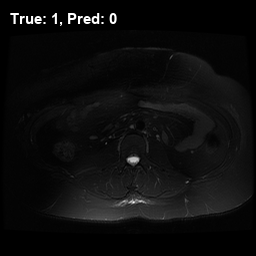

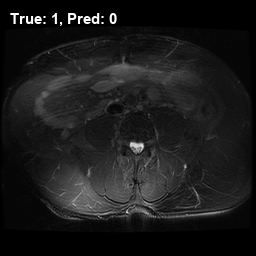

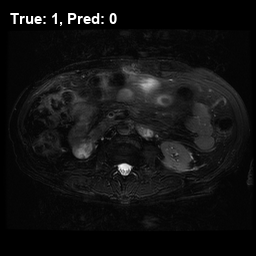

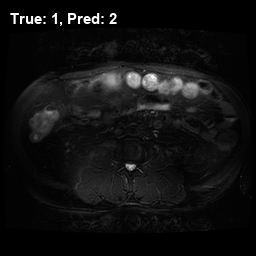

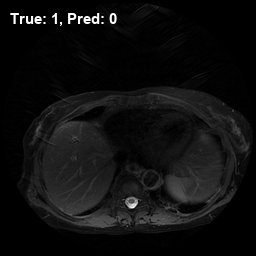

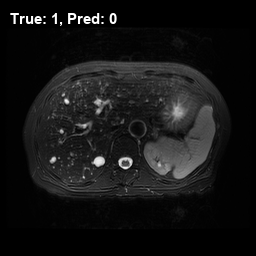

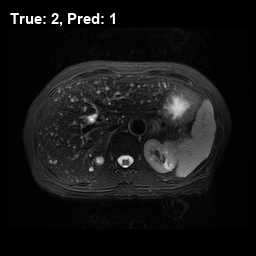

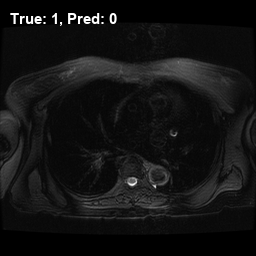

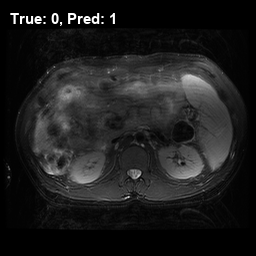

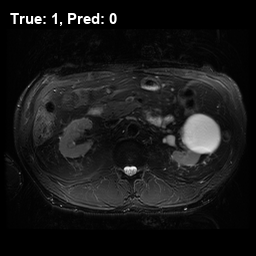

In [22]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/data/jma/model/resnet10/old_data/"

kernel_sizes = [3,4,5,6,7,8,9,19]
filter_sizes = [4, 10, 16]

data_path = "./data/data_initial_labels_png/"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=5
filter_size=8
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet10_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    